# Libraries

In [18]:
import pandas as pd
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
import math as mt
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
sns.set()

# Loading Data and Initial Treatment 

In [3]:
#loading data

min_temp_df = pd.read_csv('daily-minimum-temperatures-in-me.csv',on_bad_lines = 'warn')

display(min_temp_df.info())
min_temp_df.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Date                                                           3650 non-null   object
 1   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


None

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
1748,10/16/1985,16
623,9/16/1982,10.1


In [4]:
min_temp_df.rename(columns = {'Date':'date',min_temp_df.columns[1]:'daily_min_temp'},inplace = True)
min_temp_df.head(2)

,date,daily_min_temp
0,1/1/1981,20.7
1,1/2/1981,17.9


In [5]:
#looking for non numeric values in temperature: 

for value,n in zip(min_temp_df.daily_min_temp,range(len(min_temp_df.daily_min_temp))):
    if re.search('\D+[^\.]\D+',value):
        print (value,f' row: {n}')

?0.2  row: 565
?0.8  row: 566
?0.1  row: 1290


In [6]:
#Lets take a closer look at these weird values:

display(min_temp_df[564:568])
display(min_temp_df[1289:1292])

,date,daily_min_temp
564,7/19/1982,5.2
565,7/20/1982,?0.2
566,7/21/1982,?0.8
567,7/22/1982,0.9


,date,daily_min_temp
1289,7/13/1984,0.7
1290,7/14/1984,?0.1
1291,7/15/1984,0.9


the question mark usually replaces a character that cannot be interpreted. Considering that the temperatures near the date in question are close to 0, it seems reasonable to assume that this interrogation is related to a negative sign.

In [7]:
#transforming data types:

min_temp_df2 = min_temp_df.copy()
min_temp_df2.daily_min_temp = [float(i.replace('?','-')) for i in min_temp_df.daily_min_temp]
min_temp_df2.date = pd.to_datetime(min_temp_df2.date, format="%m/%d/%Y") 

display(min_temp_df2.dtypes)
min_temp_df2.head(2)

date              datetime64[ns]
daily_min_temp           float64
dtype: object

,date,daily_min_temp
0,1981-01-01,20.7
1,1981-01-02,17.9


In [8]:
#General Checking:

print(f'Duplicate dates: {min_temp_df2.date.duplicated().sum()}')
print('\nNan values:')
min_temp_df2.isnull().sum()

Duplicate dates: 0

Nan values:


date              0
daily_min_temp    0
dtype: int64

In [9]:
min_temp_df2.describe()

,daily_min_temp
count,3650.000000
mean,11.177151
std,4.073492
min,-0.800000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [10]:
min_temp_df2.to_csv('daily-minimum-temperatures-in-me-treated.csv',index = False)

# Time Series Graphics

In [11]:
#preparing formatting

def celsius_formatter(x, pos):
    'The two args are the value and tick position'
    return '%1.1f°C' % (x)

celsius_formatter = FuncFormatter(celsius_formatter)

plt.rcParams.update({'ytick.labelsize': 16.0,
                     'xtick.labelsize': 16.0,
                     'axes.labelsize': 16.0,
                     'axes.xmargin': 0.0})

sns.set_style("white")

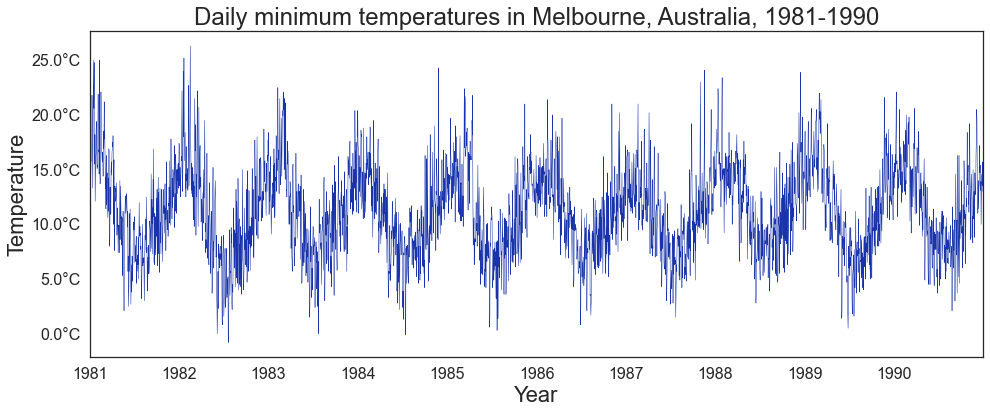

In [12]:
fig, ax1 = plt.subplots(figsize=(16,6))

sns.lineplot(x=min_temp_df2.date,
             y=min_temp_df2.daily_min_temp,
            color ='#1833ab',lw =0.5,ax = ax1)

ax1.set_title("Daily minimum temperatures in Melbourne, Australia, 1981-1990",fontsize = 24)
ax1.set_xlabel('Year',fontsize = 22) #caracteristica das labels 
ax1.set_ylabel('Temperature',fontsize = 22)
ax1.yaxis.set_major_formatter(FuncFormatter(celsius_formatter))
#ax1.margins(0,0.1)
plt.show()

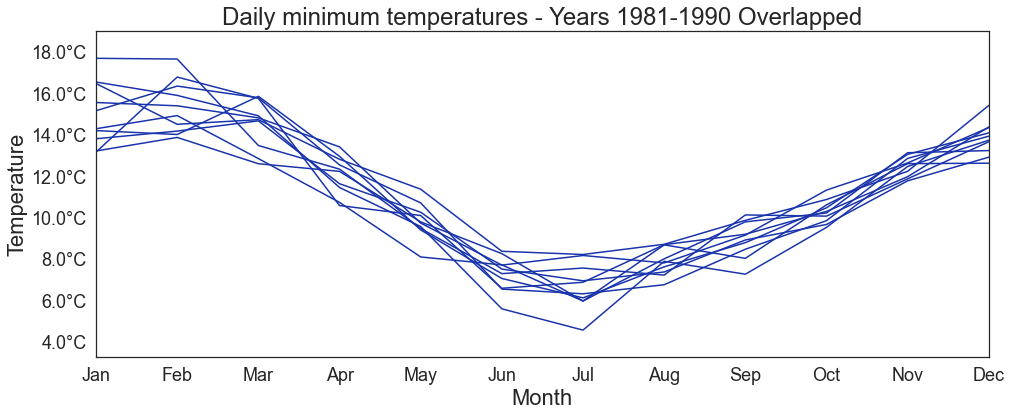

In [13]:
fig, ax1 = plt.subplots(figsize=(16,6))

for year in range(1981,1992):
    year_df = min_temp_df2[min_temp_df2['date'].dt.year == year]
    sns.lineplot(x=year_df.date.dt.month_name().str[0:3],y=year_df.daily_min_temp,color ='#1833ab',ci=None,lw =1.5,ax=ax1)

ax1.set_title("Daily minimum temperatures - Years 1981-1990 Overlapped",fontsize = 24)
ax1.set_xlabel('Month',fontsize = 22) #caracteristica das labels 
ax1.set_ylabel('Temperature',fontsize = 22)
ax1.tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(FuncFormatter(celsius_formatter))
ax1.margins(0,0.1)
plt.show()

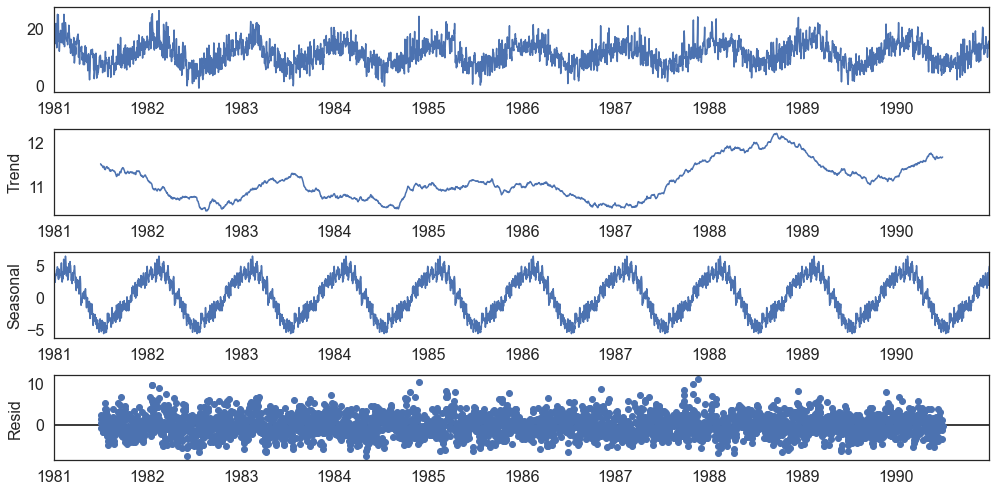

In [14]:
#Seasonal Decompose

seasonal_df = min_temp_df2.copy()
seasonal_df.set_index('date', inplace=True)

plt.rcParams['figure.figsize'] = (14, 7)

#We’ll select a additive model since it would appear the amplitude of the cycles is NOT increasing with time
seasonal_decompose(seasonal_df, model='additive',period =365).plot()
plt.show()

It is clear that the data show strong seasonality, no well defined trend, and no cyclical behavior.We can also note the mean resid close to 0, so our df won't need any transformations

# Autocorrelation analysis

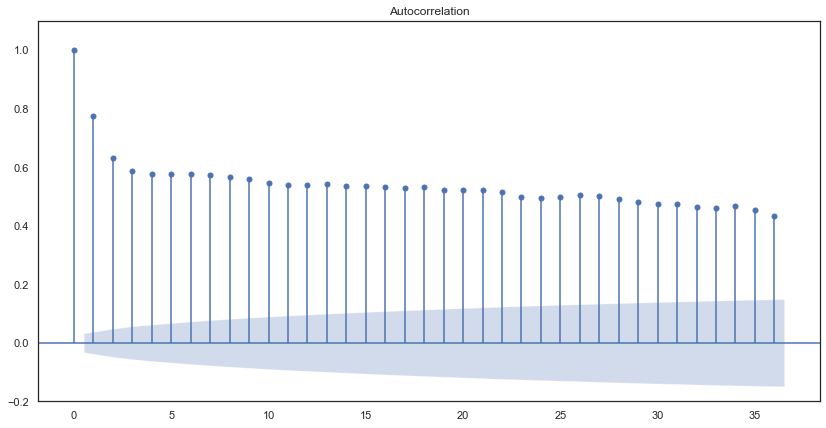

In [26]:
#Starting with a quick view of the autocorrelation:

sns.set_style('white')
plot_acf(min_temp_df2.daily_min_temp)
plt.ylim(-0.2,1.1)
plt.show()

the plot_acf function is a really cool tool to quickly see the autocorrelation in a series. However, it is not 100% complete, because with it we can't see the influence of potential outliers or other types of non-linear relationship between the series.

For a more complete study we will take the following steps:

In [27]:
min_temp_df3 = min_temp_df2.copy()

for n in range(1,10):
    col_name = 'daily_min_temp_lag' + str(n)
    min_temp_df3[col_name] = min_temp_df3['daily_min_temp'].shift(n)

min_temp_df3.tail()

,date,daily_min_temp,daily_min_temp_lag1,daily_min_temp_lag2,daily_min_temp_lag3,daily_min_temp_lag4,daily_min_temp_lag5,daily_min_temp_lag6,daily_min_temp_lag7,daily_min_temp_lag8,daily_min_temp_lag9
3645,1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2
3646,1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7
3647,1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4
3648,1990-12-30,15.7,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1
3649,1990-12-31,13.0,15.7,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2


In [28]:
#To work with lag we need to drop the firts observations 

min_temp_df3.dropna(inplace = True)
min_temp_df3.reset_index(drop= True, inplace = True)
min_temp_df3.head(2)

,date,daily_min_temp,daily_min_temp_lag1,daily_min_temp_lag2,daily_min_temp_lag3,daily_min_temp_lag4,daily_min_temp_lag5,daily_min_temp_lag6,daily_min_temp_lag7,daily_min_temp_lag8,daily_min_temp_lag9
0,1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
1,1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9


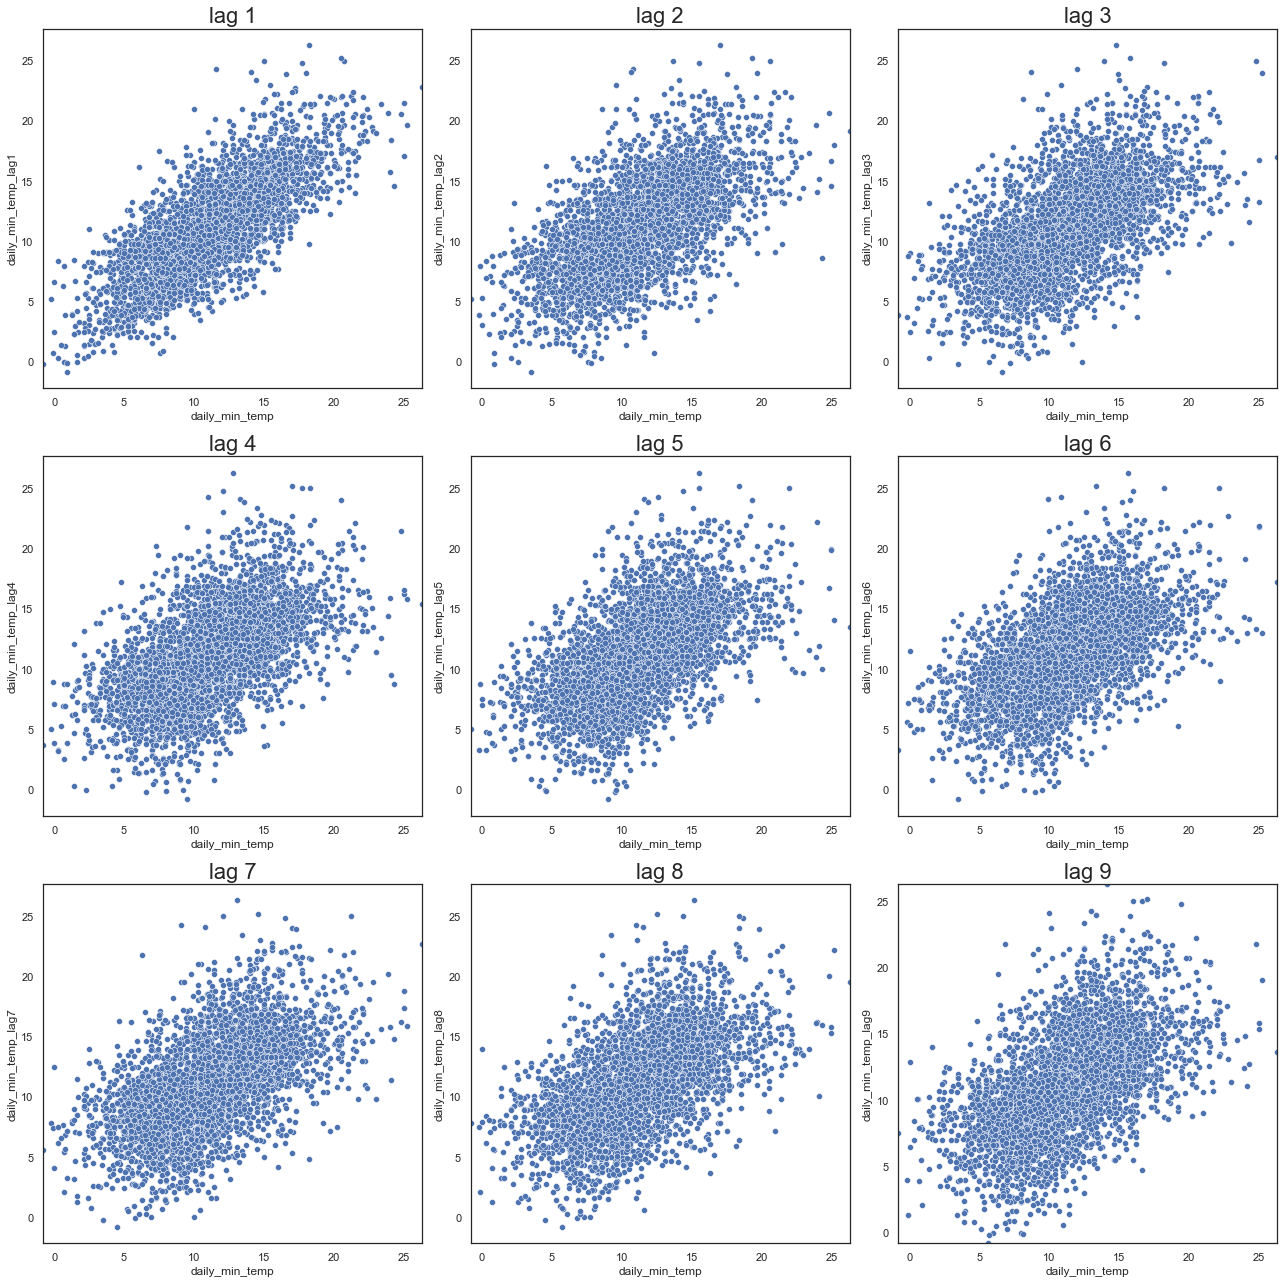

In [29]:
fig, ax = plt.subplots(3,3,figsize=(18,18))

j,i = 0,0
for col,n in zip(min_temp_df3.columns[2:],range(9)):    
    sns.scatterplot(x=min_temp_df3['daily_min_temp'], y=min_temp_df3[col],ax = ax[j,i])
    ax[j,i].set_title('lag '+str(n+1),fontsize = 22)
    if i == 2:
        i = 0
        j+=1
    else:
        i+=1

plt.tight_layout()
plt.margins(0,0)
plt.show()

With this visualization we can easily identify outliers and other types of relationships. In this case, we did not observe potential outliers that would need treatment or other types of non-linear relationships. However, checking is a fundamental step to obtain a well-founded forecast.

,lag,pearson
0,daily_min_temp_lag1,0.774204
1,daily_min_temp_lag2,0.629927
2,daily_min_temp_lag3,0.585446
3,daily_min_temp_lag4,0.577880
4,daily_min_temp_lag5,0.577693
5,daily_min_temp_lag6,0.575557
6,daily_min_temp_lag7,0.575090
7,daily_min_temp_lag8,0.568722
8,daily_min_temp_lag9,0.563387


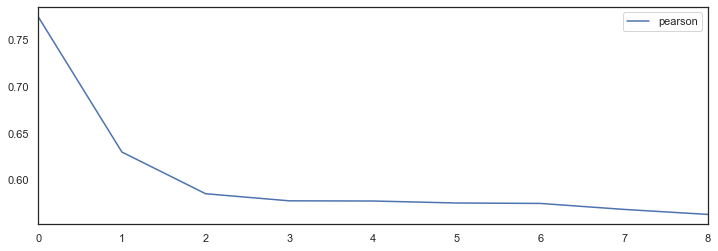

In [30]:
# Let's finish getting the pearson number, it may be useful later.

pearson_list =[]
for col in min_temp_df3.columns[2:]:
    corr, _ = pearsonr(min_temp_df3['daily_min_temp'], min_temp_df3[col])
    pearson_list.append(corr)
    
pearson_df = pd.DataFrame({'lag':min_temp_df3.columns[2:], 'pearson':pearson_list})
display(pearson_df)
pearson_df.plot(figsize=(12,4))
plt.show()